In [1]:
import os 
import sys
sys.path.append('/home/mingxuan.zhang/scGraphLLM/scGraphLLM')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from GNN_modules import *
from MLP_modules import *
import lightning.pytorch as pl
from _globals import * ## these define the indices for the special tokens 
from torch_geometric.utils import negative_sampling
from flash_transformer import GDTransformer

/hpc/mydata/mingxuan.zhang/anaconda/23.1.0-3/x86_64/envs/scllm_2/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /hpc/mydata/mingxuan.zhang/anaconda/23.1.0-3/x86_64/envs/scllm_2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [3]:
from config import *

In [4]:
torch.cuda.is_available()

True

In [5]:
vanilla_path = "/hpc/mydata/mingxuan.zhang/scGraphLLM/model_out/scGraphLLM/Rdjy0XuN/checkpoints/epoch=3-step=4742.ckpt"

In [6]:
vanilla_model = GDTransformer.load_from_checkpoint(vanilla_path, config=vanilla_manitou)

In [7]:
gdk_path = "/hpc/mydata/mingxuan.zhang/scGraphLLM/model_out/scGraphLLM/NVtvvJLu/checkpoints/epoch=2-step=3712.ckpt"

In [8]:
gdk_model_state_dict = torch.load(gdk_path)["state_dict"]
gdk_model_state_dict.keys()

/tmp/ipykernel_1340049/3366974342.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gdk_model_state_dict = torch.load(gdk_path)["state_dict"]


odict_keys(['link_prediction_head.net.0.weight', 'link_prediction_head.net.0.bias', 'link_prediction_head.net.1.weight', 'link_prediction_head.net.1.bias', 'link_prediction_head.net.3.weight', 'link_prediction_head.net.3.bias', 'node_embedding.weight', 'gene_prediction_head.net.0.weight', 'gene_prediction_head.net.0.bias', 'gene_prediction_head.net.1.weight', 'gene_prediction_head.net.1.bias', 'gene_prediction_head.net.3.weight', 'gene_prediction_head.net.3.bias', 'rank_prediction_head.net.0.weight', 'rank_prediction_head.net.0.bias', 'rank_prediction_head.net.1.weight', 'rank_prediction_head.net.1.bias', 'rank_prediction_head.net.3.weight', 'rank_prediction_head.net.3.bias', 'transformer_encoder.self_attention.out_proj.weight', 'transformer_encoder.self_attention.out_proj.bias', 'transformer_encoder.wqkv.Wqkv.weight', 'transformer_encoder.wqkv.Wqkv.bias', 'transformer_encoder.wqkv.Wp.weight', 'transformer_encoder.wqkv.Wp.bias', 'transformer_encoder.ff.0.weight', 'transformer_encoder.f

In [9]:
gdk_model = GDTransformer(config=graph_kernel_attn_manitou)
cpt = torch.load(gdk_path)
filtered_state_dict = {k: v for k, v in cpt["state_dict"].items() if ("transformer_encoder.wqkv.Wp.weight" not in k) & ("transformer_encoder.wqkv.Wp.bias" not in k)}

/tmp/ipykernel_1340049/381428171.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cpt = torch.load(gdk_path)


In [10]:
filtered_state_dict.keys()

dict_keys(['link_prediction_head.net.0.weight', 'link_prediction_head.net.0.bias', 'link_prediction_head.net.1.weight', 'link_prediction_head.net.1.bias', 'link_prediction_head.net.3.weight', 'link_prediction_head.net.3.bias', 'node_embedding.weight', 'gene_prediction_head.net.0.weight', 'gene_prediction_head.net.0.bias', 'gene_prediction_head.net.1.weight', 'gene_prediction_head.net.1.bias', 'gene_prediction_head.net.3.weight', 'gene_prediction_head.net.3.bias', 'rank_prediction_head.net.0.weight', 'rank_prediction_head.net.0.bias', 'rank_prediction_head.net.1.weight', 'rank_prediction_head.net.1.bias', 'rank_prediction_head.net.3.weight', 'rank_prediction_head.net.3.bias', 'transformer_encoder.self_attention.out_proj.weight', 'transformer_encoder.self_attention.out_proj.bias', 'transformer_encoder.wqkv.Wqkv.weight', 'transformer_encoder.wqkv.Wqkv.bias', 'transformer_encoder.ff.0.weight', 'transformer_encoder.ff.0.bias', 'transformer_encoder.ff.2.weight', 'transformer_encoder.ff.2.bia

In [11]:
gdk_model.load_state_dict(filtered_state_dict, strict=False)

<All keys matched successfully>

In [12]:
gdk_model.to("cuda")

GDTransformer(
  (link_prediction_head): LinkPredictHead(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (node_embedding): Embedding(19502, 128, padding_idx=0)
  (gene_prediction_head): RobertaLMHead(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=19247, bias=True)
    )
  )
  (rank_prediction_head): RobertaLMHead(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=255, bias=True)
    )
  )
  (transformer_en

In [13]:
from data import *
from torch.nn.utils.rnn import pad_sequence

In [14]:
def collate_fn(batch):
    data = { "orig_gene_id" : [], "orig_rank_indices" : [], "gene_mask" : [], 
            "rank_mask" : [], "both_mask" : [], "edge_index": [], "num_nodes" :[], 
            "spectral_pe" : [], "dataset_name" : [] }
    
    # Make a dictionary of lists from the list of dictionaries
    for b in batch:
        for key in data.keys():
            data[key].append(b[key])

    # Pad these dictionaries of lists
    for key in data.keys():
        if (key != "dataset_name") & (key != "edge_index") & (key != "num_nodes"):
            data[key] = pad_sequence(data[key], batch_first=True)

    return data

In [15]:
transformer_data_module = GraphTransformerDataModule(graph_kernel_attn_4096.data_config, collate_fn=collate_fn)
train_transformer_dl = transformer_data_module.train_dataloader()
val_transformer_dl = transformer_data_module.val_dataloader()

/hpc/projects/group.califano/GLM/data/cxg_cache_4096/train
/hpc/projects/group.califano/GLM/data/cxg_cache_4096/valSG
/hpc/projects/group.califano/GLM/data/cxg_cache_4096/valHOG


In [16]:
val_hog_data = val_transformer_dl[-1]
val_sg_data = val_transformer_dl[0]

In [17]:
from MLP_modules import LinkPredictHead
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import tqdm
import matplotlib.pyplot as plt
import random

In [18]:
def link_pred_loss(predictor, node_embedding, mask_locs, edge_index_list):
    pos_out = []
    neg_out = []
    pos_labels = []
    neg_labels = []

    batch_size, num_nodes, embed_dim = node_embedding.shape
    device = node_embedding.device

    for batch in range(batch_size):
        masked_nodes = torch.where(mask_locs[batch])[0]
        if masked_nodes.numel() == 0:
            continue
        masked_nodes = masked_nodes.to(device)
        edge_index = edge_index_list[batch].to(device)
        masked_nodes_bool = torch.zeros(num_nodes, dtype=torch.bool, device=device)
        masked_nodes_bool[masked_nodes] = True
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        edge_mask = masked_nodes_bool[src_nodes] & masked_nodes_bool[dst_nodes]
        pos_edge_index = edge_index[:, edge_mask]
        if pos_edge_index.size(1) == 0:
            continue

        num_neg_samples = pos_edge_index.size(1)
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=num_nodes,
            num_neg_samples=num_neg_samples,
            method='sparse'
        ).to(device)

        # Positive scores
        src_emb_pos = node_embedding[batch, pos_edge_index[0]]
        dst_emb_pos = node_embedding[batch, pos_edge_index[1]]
        pos_scores = predictor(src_emb_pos, dst_emb_pos)
        pos_out.append(pos_scores)
        pos_labels.append(torch.ones_like(pos_scores, device=device))  # Positive labels (1)

        # Negative scores
        src_emb_neg = node_embedding[batch, neg_edge_index[0]]
        dst_emb_neg = node_embedding[batch, neg_edge_index[1]]
        neg_scores = predictor(src_emb_neg, dst_emb_neg)
        neg_out.append(neg_scores)
        neg_labels.append(torch.zeros_like(neg_scores, device=device))  # Negative labels (0)

    if pos_out:
        pos_out = torch.cat(pos_out, dim=0)
        neg_out = torch.cat(neg_out, dim=0)
        pos_labels = torch.cat(pos_labels, dim=0)
        neg_labels = torch.cat(neg_labels, dim=0)

        # Loss calculation
        pos_loss = -torch.log(pos_out + 1e-10).mean()
        neg_loss = -torch.log(1 - neg_out + 1e-10).mean()

        # Concatenate outputs and labels
        all_outputs = torch.cat([pos_out, neg_out], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        return pos_loss + neg_loss, all_outputs, all_labels
    else:
        return torch.tensor(0.0, device=device), torch.tensor([], device=device), torch.tensor([], device=device)

In [19]:
def send_to_gpu(data):
    if isinstance(data, torch.Tensor):
        return data.to('cuda')  # Send tensor to GPU
    elif isinstance(data, list):
        return [send_to_gpu(item) for item in data]  # Recursively process lists
    elif isinstance(data, dict):
        return {key: send_to_gpu(value) for key, value in data.items()}  # Recursively process dicts
    else:
        return data  # If not a tensor or list/dict, leave unchanged

In [20]:
def fine_tune_train_step(pretrained_model, ft_model, batch, opt):
    pretrained_model.eval()
    ft_model.train()
    batch = send_to_gpu(batch)
    embedding, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrained_model(batch)
    L_g, _, _ = link_pred_loss(ft_model, embedding, mask_locs[0], edge_index_list)
    L_g.backward()
    opt.step()
    return L_g

def fine_tune(train_dataloader, pretrained_model, ft_model, lr=1e-3, num_epochs=100, max_num_batches=200):
    train_losses = []
    opt = torch.optim.Adam(ft_model.parameters(), lr=1e-3, weight_decay=1e-4)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        train_loss_epoch = 0
        train_batches = len(train_dataloader)
        num_batches = 0
        for batch in  tqdm.tqdm(train_dataloader, desc="Training", leave=False):
            train_loss = fine_tune_train_step(pretrained_model, ft_model, batch, opt)
            train_loss_epoch += train_loss.item()
            num_batches += 1
            if num_batches >= max_num_batches:
                break
        train_loss_epoch /= train_batches
        train_losses.append(train_loss_epoch)
        print(f"Train loss: {train_loss_epoch:.4f}")
    return train_losses

def predict_and_compare(test_dataloader, pretrain1, pretrain2, model1, model2, max_num_batches=100):
    model1.eval().to("cuda")
    model2.eval().to("cuda")
    pretrain1.eval().to("cuda")
    pretrain2.eval().to("cuda")
    
    all_preds1 = []
    all_preds2 = []
    all_labels = []
    n_b = 0
    for batch in tqdm.tqdm(test_dataloader, leave=False):
        batch = send_to_gpu(batch)
        embedding1, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrain1(batch)
        embedding2, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrain2(batch)
        
        L_g1, preds1, labels = link_pred_loss(model1, embedding1, mask_locs[0], edge_index_list)
        L_g2, preds2, labels = link_pred_loss(model2, embedding2, mask_locs[0], edge_index_list)
        
        all_preds1.extend(preds1.cpu().detach().numpy())
        all_preds2.extend(preds2.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
        
        n_b += 1
        if n_b >= max_num_batches:
            break
    
    # AUROC
    fpr1, tpr1, _ = roc_curve(all_labels, all_preds1)
    fpr2, tpr2, _ = roc_curve(all_labels, all_preds2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)
    
    # PR
    p1, r1, _ = precision_recall_curve(all_labels, all_preds1)
    p2, r2, _ = precision_recall_curve(all_labels, all_preds2)
    apr1 = average_precision_score(all_labels, all_preds1)
    apr2 = average_precision_score(all_labels, all_preds2)
    
    return fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2

In [30]:
def auroc_curves(fpr1, tpr1, auc1, fpr2, tpr2, auc2):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, label=f"fine-tune w. vanilla embedding (AUC = {auc1:.3f})")
    plt.plot(fpr2, tpr2, label=f"fine-tune w. GraphDKA embedding (AUC = {auc2:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Fine tuning AUROC, link pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [31]:
def pr_curves(precision1, recall1, ap1, precision2, recall2, ap2):
    plt.figure(figsize=(8, 6))

    # Plot the first PR curve
    plt.plot(recall1, precision1, label=f"fine-tune w. vanilla embedding (Avg. Prec. = {ap1:.3f})", linestyle='-', marker=None)

    # Plot the second PR curve
    plt.plot(recall2, precision2, label=f"fine-tune w. GraphDKA embedding (Avg. Prec. = {ap2:.3f})", linestyle='--', marker=None)

    # Add labels and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Fine tuning Precision-Recall Curve, link pred")
    plt.legend(loc="best")
    plt.grid()

    # Set axis limits for better visualization
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Show the plot
    plt.show()

In [23]:
def random_sample_batches(dataloader, n):
    # Convert the dataloader to a list of batches
    batches = list(dataloader)
    # Randomly sample n batches
    sampled_batches = random.sample(batches, n)
    return sampled_batches

In [24]:
vanilla_lp = LinkPredictHead(256, 1).to("cuda")
gdk_lp = LinkPredictHead(256, 1).to("cuda")

In [25]:
vanilla_loss = fine_tune(val_sg_data, pretrained_model=vanilla_model, ft_model=vanilla_lp, num_epochs=1, max_num_batches=100)

Epoch 1/1
556923
556923


Training:   0%|                                                                                                  | 0/34808 [00:00<?, ?it/s]

556923


Train loss: 0.0029


In [26]:
gdk_loss = fine_tune(val_sg_data, pretrained_model=gdk_model, ft_model=gdk_lp, num_epochs=1, max_num_batches=100)

Epoch 1/1
556923
556923


Training:   0%|                                                                                                  | 0/34808 [00:00<?, ?it/s]

556923


Train loss: 0.0014


In [27]:
fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2 = predict_and_compare(val_hog_data, 
                                                                                     vanilla_model, 
                                                                                     gdk_model, 
                                                                                     vanilla_lp, 
                                                                                     gdk_lp, max_num_batches=50)

669335


  0%|                                                                                                            | 0/41834 [00:00<?, ?it/s]

669335


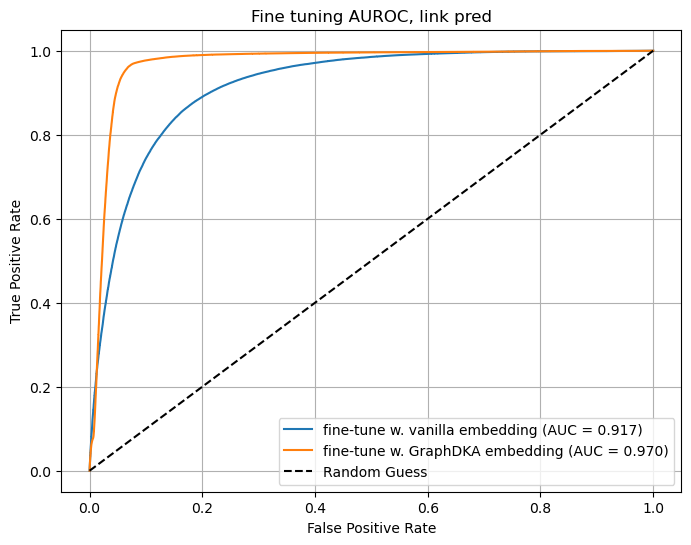

In [32]:
auroc_curves(fpr1, tpr1, auc1, fpr2, tpr2, auc2)

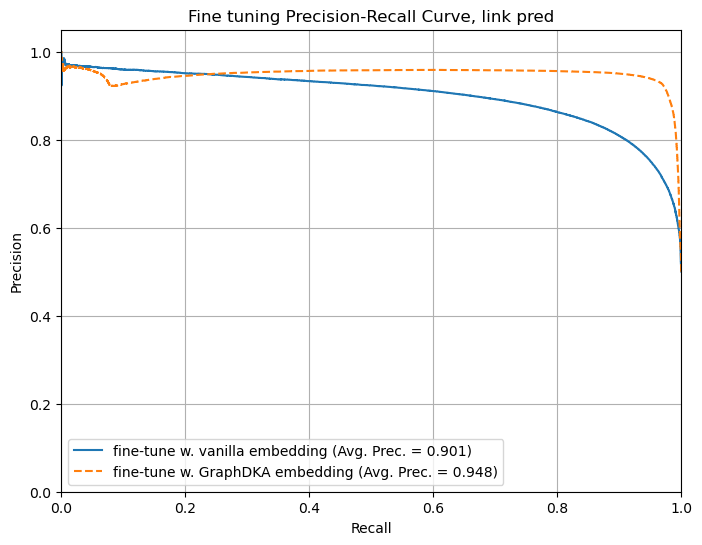

In [33]:
pr_curves(p1, r1, apr1, p2, r2, apr2)